In [1]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
import matplotlib 
import numpy as np
import os

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import callbacks, layers

In [2]:
# функции для отрисовки графиков
# https://mathformachines.com/posts/visualizing-the-loss-landscape/
class RandomCoordinates(object):
    def __init__(self, origin):
        self.origin_ = origin
        self.v0_ = normalize_weights(
            [np.random.normal(size=w.shape) for w in origin], origin
        )
        self.v1_ = normalize_weights(
            [np.random.normal(size=w.shape) for w in origin], origin
        )

    def __call__(self, a, b):
        return [
            a * w0 + b * w1 + wc
            for w0, w1, wc in zip(self.v0_, self.v1_, self.origin_)
        ]


def normalize_weights(weights, origin):
    return [
        w * np.linalg.norm(wc) / np.linalg.norm(w)
        for w, wc in zip(weights, origin)
    ]


class LossSurface(object):
    def __init__(self, model, inputs, outputs):
        self.model_ = model
        self.inputs_ = inputs
        self.outputs_ = outputs

    def compile(self, range, points, coords):
        a_grid = tf.linspace(-1.0, 1.0, num=points) ** 3 * range
        b_grid = tf.linspace(-1.0, 1.0, num=points) ** 3 * range
        loss_grid = np.empty([len(a_grid), len(b_grid)])
        for i, a in enumerate(a_grid):
            for j, b in enumerate(b_grid):
                self.model_.set_weights(coords(a, b))
                loss = self.model_.test_on_batch(
                    self.inputs_, self.outputs_, return_dict=True
                )["loss"]
                loss_grid[j, i] = loss
        self.model_.set_weights(coords.origin_)
        self.a_grid_ = a_grid
        self.b_grid_ = b_grid
        self.loss_grid_ = loss_grid

    def plot(self, range=1.0, points=24, levels=20, ax=None, **kwargs):
        xs = self.a_grid_
        ys = self.b_grid_
        zs = self.loss_grid_
        if ax is None:
            _, ax = plt.subplots(**kwargs)
            ax.set_title("The Loss Surface")
            ax.set_aspect("equal")
        # Set Levels
        min_loss = zs.min()
        max_loss = zs.max()
        levels = tf.exp(
            tf.linspace(
                tf.math.log(min_loss), tf.math.log(max_loss), num=levels
            )
        )
        # Create Contour Plot
        CS = ax.contour(
            xs,
            ys,
            zs,
            levels=levels,
            cmap="magma",
            linewidths=0.75,
            norm= matplotlib.colors.LogNorm(vmin=min_loss, vmax=max_loss * 2.0),
        )
        ax.clabel(CS, inline=True, fontsize=8, fmt="%1.2f")
        return ax
    def z(self, range=1.0, points=240, levels=20, ax=None, **kwargs):
        xs = self.a_grid_
        ys = self.b_grid_
        zs = self.loss_grid_
        return xs, ys, zs

from sklearn.decomposition import PCA

# Some utility functions to reshape network weights
def vectorize_weights_(weights):
    vec = [w.flatten() for w in weights]
    vec = np.hstack(vec)
    return vec


def vectorize_weight_list_(weight_list):
    vec_list = []
    for weights in weight_list:
        vec_list.append(vectorize_weights_(weights))
    weight_matrix = np.column_stack(vec_list)
    return weight_matrix


def shape_weight_matrix_like_(weight_matrix, example):
    weight_vecs = np.hsplit(weight_matrix, weight_matrix.shape[1])
    sizes = [v.size for v in example]
    shapes = [v.shape for v in example]
    weight_list = []
    for net_weights in weight_vecs:
        vs = np.split(net_weights, np.cumsum(sizes))[:-1]
        vs = [v.reshape(s) for v, s in zip(vs, shapes)]
        weight_list.append(vs)
    return weight_list


def get_path_components_(training_path, n_components=2):
    # Vectorize network weights
    weight_matrix = vectorize_weight_list_(training_path)
    # Create components
    pca = PCA(n_components=2, whiten=True)
    components = pca.fit_transform(weight_matrix)
    # Reshape to fit network
    example = training_path[0]
    weight_list = shape_weight_matrix_like_(components, example)
    return pca, weight_list
  
class PCACoordinates(object):
    def __init__(self, training_path):
        origin = training_path[-1]
        self.pca_, self.components = get_path_components_(training_path)
        self.set_origin(origin)

    def __call__(self, a, b):
        return [
            a * w0 + b * w1 + wc
            for w0, w1, wc in zip(self.v0_, self.v1_, self.origin_)
        ]

    def set_origin(self, origin, renorm=True):
        self.origin_ = origin
        if renorm:
            self.v0_ = normalize_weights(self.components[0], origin)
            self.v1_ = normalize_weights(self.components[1], origin)

def weights_to_coordinates(coords, training_path):
    """Project the training path onto the first two principal components
using the pseudoinverse."""
    components = [coords.v0_, coords.v1_]
    comp_matrix = vectorize_weight_list_(components)
    # the pseudoinverse
    comp_matrix_i = np.linalg.pinv(comp_matrix)
    # the origin vector
    w_c = vectorize_weights_(training_path[-1])
    # center the weights on the training path and project onto components
    #print(training_path)
    coord_path = np.array(
        [
            comp_matrix_i @ (vectorize_weights_(weights) - w_c)
            for weights in training_path
        ]
    )
    return coord_path


def plot_training_path(coords, training_path, ax=None, end=None, **kwargs):
    path = weights_to_coordinates(coords, training_path)
    if ax is None:
        fig, ax = plt.subplots(**kwargs)
    colors = range(path.shape[0])
    end = path.shape[0] if end is None else end
    norm = plt.Normalize(0, end)
    ax.scatter(
        path[:, 0], path[:, 1], s=4, c=colors, cmap="cividis", norm=norm,
    )
    return ax

In [3]:
def loss_surface_coord(model, x, y, BATCH_SIZE = 64, NUM_EXAMPLES = 1000, range = 0.4 ):
  model.compile(
    loss='mse',
    optimizer='sgd',
    )
  ds = (
      tf.data.Dataset.from_tensor_slices((x, y))
      .repeat()
      .shuffle(NUM_EXAMPLES)
      .batch(BATCH_SIZE)
  )

  training_path = [model.get_weights()]
  # Callback to collect weights as the model trains
  collect_weights = callbacks.LambdaCallback(
      on_epoch_end=(
          lambda batch, logs: training_path.append(model.get_weights())
      )
  )

  history = model.fit(
      ds,
      steps_per_epoch=1,
      epochs=40,
      callbacks=[collect_weights],
      verbose=0,
  )

  pcoords = PCACoordinates(training_path)
  loss_surface = LossSurface(model, x, y)
  loss_surface.compile(points=40, coords=pcoords, range=range)
  ax = loss_surface.plot(dpi=150)
  plot_training_path(pcoords, training_path, ax)
  path = weights_to_coordinates(pcoords, training_path)
  return path

Статья : https://arxiv.org/pdf/1806.01528.pdf

We start by defining ReLU neural networks. 

***Definition 2.1.***

 Let $L \geq 2, d, N_{1}, \ldots, N_{L} \in \mathbb{N} .$ A map $\Phi: \mathbb{R}^{d} \rightarrow \mathbb{R}^{N_{L}}$ given by

$$
\Phi(x)=W_{L}\left(\rho\left(W_{L-1}\left(\rho\left(\ldots \rho\left(W_{1}(x)\right)\right)\right)\right)\right)
$$

with affine linear maps $W_{\ell}: \mathbb{R}^{N_{\ell-1}} \rightarrow \mathbb{R}^{N_{\ell}}, W_{\ell}(x)=A_{\ell} x+b_{\ell}, 1 \leq \ell \leq L, A_{\ell} \in \mathbb{R}^{N_{\ell} \times N_{\ell-1}}, b_{\ell} \in$
$\mathbb{R}^{N_{\ell}}$, 

and the ReLU activation function $\rho(x)=\max (x, 0), x \in \mathbb{R}$, acting component-wise is called $a$ ReLU neural network.

 Here $N_{0}=d$ is the dimension of the input layer, $N_{L}$ denotes the dimension of the output layer, 
 
 $L=\mathcal{L}(\Phi)$ stands for the number of layers (not counting the input layer) of the network,
 
  $N_{1}, \ldots, N_{L-1}$ are the dimensions of the $L-1$ hidden layers, 
  
  $M=\mathcal{M}(\Phi):=\max _{\ell} N_{\ell}$ denotes the network width, and the total number of nonzero weights in the network, i.e., the total number of nonzero entries in $A_{\ell}, b_{\ell}, \ell=1, \ldots, N$, is referred to as network connectivity.

***We denote the class of ReLU networks $\Phi: \mathbb{R}^{d} \rightarrow \mathbb{R}^{N_{L}}$ with no more than $L$ layers, width no more than $M$, input dimension $d$, and output dimension $N_{L}$ by $\mathcal{N} \mathcal{N}_{L, M, d, N_{L}}$. Note that the connectivity of $\Phi$ is upper-bounded by $L M(M+1)$.***

**Proposition 3.1.**

 There exist constants $C, D>0$ and networks $\Phi_{\epsilon} \in \mathcal{N N}_{L, 5,1,1}$ with $L \leq$ $C(\log (1 / \epsilon)), \epsilon \rightarrow 0$, such that

$$
\left\|\Phi_{\epsilon}(x)-x^{2}\right\|_{L \propto[0,1]} \leq \epsilon, ~~~~~(2)
$$

and with the weights of $\Phi_{e}$ bounded (in absolute value) by $D .$
Proof. Consider the "sawtooth" function $g:[0,1] \rightarrow[0,1]$,

$$
g(x)=\left\{\begin{array}{ll}
2 x, & \text { if } x<\frac{1}{2} \\
2(1-x), & \text { if } x \geq \frac{1}{2}
\end{array}\right.
~~~~~~~~(3)$$

along with its $s$ -fold composition

$$
g_{s}=\underbrace{g \circ g \circ \cdots \circ g}, \quad s \geq 0, ~~~~~~~~~~(4)
$$

where $g_{0}(x):=x$ and $g_{1}(x):=g(x)$. We next briefly review a fundamental result from [12] showing how the function $f(x):=x^{2}, x \in[0,1]$, can be approximated by linear combinations of $s$ -fold compositions $g_{s}$. Specifically, let $f_{m}$ be the piecewise linear interpolation of $f$ with $2^{m}+1$ uniformly spaced "knots" according to

$$
f_{m}\left(\frac{k}{2^{m}}\right)=\left(\frac{k}{2^{m}}\right)^{2}, \quad k=0, \ldots, 2^{m}, \quad m \in \mathbb{N}_{0}
$$

The function $f_{m}$ approximates $f$ with error $\epsilon_{m}=2^{-2 m-2}$ in the sense of

$$
\left\|f_{m}(x)-x^{2}\right\|_{L^{\infty}[0,1]} \leq 2^{-2 m-2} .
$$

Next, note that we can refine interpolations in the sense of going from $f_{m-1}$ to $f_{m}$ by adjustment with a sawtooth function according to

$$
f_{m}(x)=f_{m-1}(x)-\frac{g_{m}(x)}{2^{2 m}} ~~~~~~(5)
$$

This leads to the representation

$$
f_{m}(x)=x-\sum_{n=1}^{m} \frac{g_{s}(x)}{2^{2 s}} ~~~~~(6)
$$

While Yarotsky's construction [12] is finalized by realizing (6) with the help of skip connections, we proceed by devising an equivalent fully connected network of width $5 .$ As $g(x)=2 \rho(x)-4 \rho(x-$ $1 / 2)+2 \rho(x-1)$, it follows that

$$
g_{m}=2 \rho\left(g_{m-1}\right)-4 \rho\left(g_{m-1}-1 / 2\right)+2 \rho\left(g_{m-1}-1\right), ~~~~~ (7)
$$
and consequently (5) can be rewritten as

$$
f_{m}=\rho\left(f_{m-1}\right)-\rho\left(-f_{m-1}\right)-2^{-2 m}\left(2 \rho\left(g_{m-1}\right)-4 \rho\left(g_{m-1}-1 / 2\right)+2 \rho\left(g_{m-1}-1\right)\right) ~~~~~~~(8)
$$

Equivalently, $(7),(8)$ can be cast as a composition of affine linear maps and a ReLU nonlinearity according to

$$
\left(\begin{array}{l}
g_{m} \\
f_{m}
\end{array}\right)=W_{1 }{\rho}\left(W_{2}\left(\begin{array}{l}
g_{m-1} \\
f_{m-1}
\end{array}\right)\right)  ~~~~~~~(9)
$$

with

$$
W_{1}(x)=\left(\begin{array}{cc}
2 & -2^{-2 m+1} \\
-4 & 2^{-2 m+2} \\
2 & -2^{-2 m+1} \\
0 & 1 \\
0 & -1
\end{array}\right)^{\top}\left(\begin{array}{l}
x_{1} \\
x_{2} \\
x_{3} \\
x_{4} \\
x_{5}
\end{array}\right), \quad W_{2}(x)=\left(\begin{array}{cc}
1 & 0 \\
1 & 0 \\
1 & 0 \\
0 & 1 \\
0 & -1
\end{array}\right)\left(\begin{array}{l}
x_{1} \\
x_{2}
\end{array}\right)-\left(\begin{array}{c}
0 \\
1 / 2 \\
1 \\
0 \\
0
\end{array}\right) ~~~~~~~~~~(10)
$$

Applying (9) iteratively initialized with $g_{0}(x)=x, f_{0}(x)=x$ shows that $f_{m}$ can be represented as a ReLU network in $\mathcal{N} \mathcal{N}_{m+1,5,1,1}$ with weights uniformly bounded (in magnitude) by 4 . With $\epsilon_{m}=2^{-2 m-2}$ and hence $\log \left(1 / \epsilon_{m}\right)=2 m+2$, the statement follows.

#**1 раздел.** 

Посмотрим на "sawtooth" функции $g:[0,1] \rightarrow[0,1]$:


$$
g(x)=\left\{\begin{array}{ll}
2 x, & \text { if } x<\frac{1}{2} \\
2(1-x), & \text { if } x \geq \frac{1}{2}
\end{array}\right.
~~~~~~~~(3)$$

along with its $s$ -fold composition

$$
g_{s}=\underbrace{g \circ g \circ \cdots \circ g}, \quad s \geq 0, ~~~~~~~~~~(4)
$$

In [4]:
def g(x):
  if x < 0.5:
    return 2*x
  else:
    return 2*(1-x)

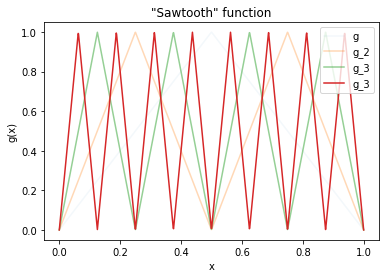

In [5]:
plt_x = np.linspace(0, 1, 1000)
plt.plot(plt_x, [g(i) for i in plt_x ], label = 'g', alpha=0.05)
plt.plot(plt_x, [g(g(i)) for i in plt_x ] , label = 'g_2', alpha=0.3)
plt.plot(plt_x, [g(g(g(i))) for i in plt_x ] , label = 'g_3', alpha=0.5)
plt.plot(plt_x, [g(g(g(g(i)))) for i in plt_x ] , label = 'g_3', alpha=1)
plt.xlabel('x')
plt.ylabel('g(x)')
plt.title('"Sawtooth" function')
plt.legend()

## Итерационная аппроксимация параболы

Функция, которая строит матрицу $A_1$ для первого слоя $W_1(x) = A_1 x $, где
$$
A_{1}(m)=\left(\begin{array}{cc}
2 & -2^{-2 m+1} \\
-4 & 2^{-2 m+2} \\
2 & -2^{-2 m+1} \\
0 & 1 \\
0 & -1
\end{array}\right)^{\top}
$$

In [6]:
def do_A1(m):
  return np.array([[2., -4., 2.,  0., 0.],
                    [-2**(-2*m+1), 2**(-2*m+2), -2**(-2*m+1),  1,  -1]])

Второй слой $W_2(x) = A_2 x+ b_2$, где
$$\quad A_{2}=\left(\begin{array}{cc}
1 & 0 \\
1 & 0 \\
1 & 0 \\
0 & 1 \\
0 & -1
\end{array}\right)
, ~~b_2 = \left(\begin{array}{c}
0 \\
1 / 2 \\
1 \\
0 \\
0
\end{array}\right) $$

Создадим функцию `it_pr`, которая для каждой точки будет строить $x^2$ по фурмулам (9):

$$
\left(\begin{array}{l}
g_{m} \\
f_{m}
\end{array}\right)=W_{1 }{\rho}\left(W_{2}\left(\begin{array}{l}
g_{m-1} \\
f_{m-1}
\end{array}\right)\right)
$$

На вход такой функции будет подаваться вектор:
$$\left(\begin{array}{l}
g_{0} \\ f_{0}
\end{array}\right)=\left(\begin{array}{l}
x_0 \\ x_0 
\end{array}\right),$$
 на выходе получим 
$\left(\begin{array}{l}
g_{m} \\
f_{m}
\end{array}\right)$, где нас будет интересовать $f_m$

Аппроксимация $x^2$ по итерациям:

In [7]:
def it_pr(xx, mm):
  " xx - отрезок аппроксимации, mm - количество шагов итерации"
  pr = []
  A2 = np.array([[1., 1., 1.,  0., 0.],
                 [0., 0., 0.,  1.,  -1.]])

  b2 = np.array([0., 0.5, 1., 0., 0.])

  for x0 in xx:
    x_history = [x0]
    for m in range(mm):
      A1 = do_A1(m+1)
      W2gf = np.dot( x_history[m], A2) - b2 
      x1x2 = tf.nn.relu(W2gf) 
      W1x1x2 = np.dot(A1, x1x2)
      x_history.append(W1x1x2)
    pr.append(x_history[-1])
  return pr

In [8]:
N = 100
a = 1e-2
x = np.linspace(a, 1, N)
xx = [[i, i] for i in x]
y = np.linspace(a, 1, N)**2
mm = 9
y_pred = np.array(it_pr( xx, mm))

Будем сравнивать в дальнейшем относительную ошибку, которая вычилсяется по формуле: 
$$
R S E (y_{pr}, y_{true}) =\frac{\left\|y_{p r}-y_{t rue}\right\|_{2}}{\left\|y_{t rue}\right\|_{2}}=\frac{1}{n} \sqrt{\sum_{i}^{n}\left(\frac{y_{p r}^{(i)}-y_{t rue}^{(i)}}{y_{t rue}^{(i)}}\right)^{2}}
$$

Относительная ошибка в этом случае:

In [9]:
rse = np.sum(( (y_pred.T[1] - y) / y )**2)/N
print('RSE = ', round(rse, 10))

RSE =  2.078e-07


Как и следует из теоремы 3.1, отоносительная ошибка $\epsilon_{m}=2^{-2 m-2}$, где  мы приняли  $m = 9 $

In [10]:
print(r' eps = ',round(2**(-2*9-2), 10))

 eps =  9.537e-07


# **2 раздел.** 

### Нейронная сеть с этими же весами:



Let $L \geq 2, d, N_{1}, \ldots, N_{L} \in \mathbb{N} .$ A map $\Phi: \mathbb{R}^{d} \rightarrow \mathbb{R}^{N_{L}}$ given by

$$
\Phi(x)=W_{L}\left(\rho\left(W_{L-1}\left(\rho\left(\ldots \rho\left(W_{1}(x)\right)\right)\right)\right)\right)
$$

Соберем нейронку с теми же весами (10) из статьи, приняв $L = 18$ и


$$
W_{1}(x)=\left(\begin{array}{cc}
2 & -2^{-2 m+1} \\
-4 & 2^{-2 m+2} \\
2 & -2^{-2 m+1} \\
0 & 1 \\
0 & -1
\end{array}\right)^{\top}\left(\begin{array}{l}
x_{1} \\
x_{2} \\
x_{3} \\
x_{4} \\
x_{5}
\end{array}\right), \quad W_{2}(x)=\left(\begin{array}{cc}
1 & 0 \\
1 & 0 \\
1 & 0 \\
0 & 1 \\
0 & -1
\end{array}\right)\left(\begin{array}{l}
x_{1} \\
x_{2}
\end{array}\right)-\left(\begin{array}{c}
0 \\
1 / 2 \\
1 \\
0 \\
0
\end{array}\right) ~~~~~~~~~~(10)
$$

Входные данные - числа на отрезке [0,1], распределенные равномерно:

In [11]:
NUM_EXAMPLES = 1000
BATCH_SIZE = 64
#x = tf.random.normal(shape=(NUM_EXAMPLES, 1), mean=0.5, stddev=0.1)
x = tf.random.uniform(shape=[NUM_EXAMPLES], minval = 0.01, maxval=1)
#x = abs(x)/max(abs(x))
err = tf.random.normal(shape=x.shape, stddev=0.0005)
y = (x) ** 2 + err
y = tf.squeeze(y)
ds = (tf.data.Dataset
      .from_tensor_slices((x, y))
      .shuffle(NUM_EXAMPLES)
      .batch(BATCH_SIZE))
#plt.plot(x, y, 'o', alpha=0.4)


Матрицы из статьи:

In [12]:
W2 =  tf.constant_initializer(np.array([[1., 1., 1.,  0., 0.],
                                        [0., 0., 0.,  1.,  -1.]]))
b2 =  tf.constant_initializer(-np.array([0., 0.5, 1., 0., 0.]))

def matr_W1(m):
  return  tf.constant_initializer(np.array([[2., -4., 2.,  0., 0.],
                                            [-2**(-2*m+1), 2**(-2*m+2), -2**(-2*m+1),  1,  -1]]).T)

Чтобы облегчить жизнь, добавим первый слой, который делает из одномерного вектора $x$, двумерный $(x, x)^\top$ и последний слой, который из $(y_1, y_2)^\top$ делает одномерный вектор $y_2$ .

Создаем нейронку:

In [47]:
mm = 9
BATCH_SIZE = 64
# Create a `Sequential` model and add a Dense layer as the first layer.
model = tf.keras.models.Sequential()
model.add(tf.keras.Input(shape=(1,)))
model.add(tf.keras.layers.Dense(2, 
                                use_bias=False, 
                                kernel_initializer =  tf.constant_initializer(np.array([1., 1.,]).T ))
)
for m in range(mm):
  model.add(tf.keras.layers.Dense(5, 
                                  activation='relu',
                                  use_bias=True, 
                                  kernel_initializer = W2,
                                  bias_initializer = b2  )
  )
  # Now the model will take as input arrays of shape (None, 2)
  # and output arrays of shape (None, 5).
  model.add(tf.keras.layers.Dense(2, 
                                  use_bias=False, 
                                  kernel_initializer = matr_W1(m+1))
  )

model.add(tf.keras.layers.Dense(1, 
                                use_bias=False, 
                                kernel_initializer = tf.constant_initializer(np.array([0, 1]))) 
)

model.output_shape

(None, 1)

Можно проверить веса:

In [14]:
model.weights

[<tf.Variable 'dense/kernel:0' shape=(1, 2) dtype=float32, numpy=array([[1., 1.]], dtype=float32)>,
 <tf.Variable 'dense_1/kernel:0' shape=(2, 5) dtype=float32, numpy=
 array([[ 1.,  1.,  1.,  0.,  0.],
        [ 0.,  0.,  0.,  1., -1.]], dtype=float32)>,
 <tf.Variable 'dense_1/bias:0' shape=(5,) dtype=float32, numpy=array([-0. , -0.5, -1. , -0. , -0. ], dtype=float32)>,
 <tf.Variable 'dense_2/kernel:0' shape=(5, 2) dtype=float32, numpy=
 array([[ 2. , -0.5],
        [-4. ,  1. ],
        [ 2. , -0.5],
        [ 0. ,  1. ],
        [ 0. , -1. ]], dtype=float32)>,
 <tf.Variable 'dense_3/kernel:0' shape=(2, 5) dtype=float32, numpy=
 array([[ 1.,  1.,  1.,  0.,  0.],
        [ 0.,  0.,  0.,  1., -1.]], dtype=float32)>,
 <tf.Variable 'dense_3/bias:0' shape=(5,) dtype=float32, numpy=array([-0. , -0.5, -1. , -0. , -0. ], dtype=float32)>,
 <tf.Variable 'dense_4/kernel:0' shape=(5, 2) dtype=float32, numpy=
 array([[ 2.   , -0.125],
        [-4.   ,  0.25 ],
        [ 2.   , -0.125],
        [ 

##**2.1** Необученная нейронная сеть

Не обучая сеть, посмотрим на ее работу:

In [15]:
def plot_pred(model = model):
  NUM_EXAMPLES = 1000
  #x = tf.random.normal(shape=(NUM_EXAMPLES, 1), mean=0.5, stddev=0.1)
  #x = abs(x)/max(abs(x))
  x = tf.random.uniform(shape=[NUM_EXAMPLES, 1], minval = 0.1, maxval=1)
  err = tf.random.normal(shape=x.shape, stddev=0.00005)
  y = (x) ** 2  + err
  y = tf.squeeze(y)

  pred = model.predict(x).reshape((1, -1))[0]
  rse = np.sum(( (pred - y) / y )**2)/NUM_EXAMPLES
  print('относительная ошибка:', rse)
  fig, ax = plt.subplots()
  ax.plot(x, y, 'o', alpha=0.1, label = 'true')
  ax.scatter(x, pred, color='k', label = 'pred')
  ax.legend()

относительная ошибка: 1.1161458678543569e-06


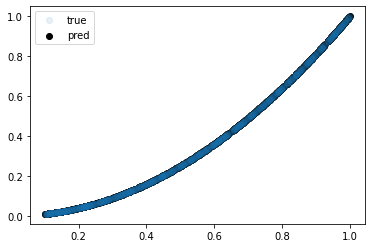

In [16]:
plot_pred()

## 2.2 Обученная модель с исходными весами из статьи.




Создадим еще одну модель с весами из статьи, но теперь ее еще и обучим.

In [17]:
def do_model_trained():
  mm = 9
  BATCH_SIZE = 64
  # Create a `Sequential` model and add a Dense layer as the first layer.
  model_trained = tf.keras.models.Sequential()
  model_trained.add(tf.keras.Input(shape=(1,)))
  model_trained.add(tf.keras.layers.Dense(2, use_bias=False, kernel_initializer =  tf.constant_initializer(np.array([1., 1.,]).T )))
  for m in range(mm):
    model_trained.add(tf.keras.layers.Dense(5, activation='relu', use_bias=True, kernel_initializer = W2, bias_initializer = b2  ))
    # Now the model will take as input arrays of shape (None, 2)
    # and output arrays of shape (None, 5).
    model_trained.add(tf.keras.layers.Dense(2,  use_bias=False, kernel_initializer = matr_W1(m+1)))
  model_trained.add(tf.keras.layers.Dense(1,  use_bias=False, kernel_initializer = tf.constant_initializer(np.array([0, 1]))) )

  return model_trained

In [18]:
def train(model, NUM_EXAMPLES = 1000, BATCH_SIZE = 64 ):

  x = tf.random.uniform(shape=[NUM_EXAMPLES], minval = 0.1, maxval=1)
  err = tf.random.normal(shape=x.shape, stddev=0.00005)
  y = (x) ** 2  + err
  y = tf.squeeze(y)

  ds = (tf.data.Dataset
        .from_tensor_slices((x, y))
        .shuffle(NUM_EXAMPLES)
        .batch(BATCH_SIZE))

  x = tf.random.uniform(shape=[NUM_EXAMPLES], minval = 0.1, maxval=1)
  err = tf.random.normal(shape=x.shape, stddev=0.005)
  y = (x) ** 2  + err
  y = tf.squeeze(y)

  model.compile(
    loss='mse',
    optimizer='sgd',
  )

  history = model.fit(
    ds,
    epochs=200,
    verbose=0,
  )
  return model


относительная ошибка: 1.0197341907769442e-06


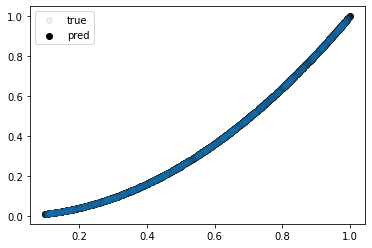

In [44]:
model_trained = train(do_model_trained())
plot_pred(model_trained)

In [45]:
  NUM_EXAMPLES = 1000
  BATCH_SIZE = 64
  x = tf.random.uniform(shape=[NUM_EXAMPLES], minval = 0.1, maxval=1)
  err = tf.random.normal(shape=x.shape, stddev=0.00005)
  y = (x) ** 2  + err
  y = tf.squeeze(y)

  ds = (tf.data.Dataset
        .from_tensor_slices((x, y))
        .shuffle(NUM_EXAMPLES)
        .batch(BATCH_SIZE))

  model_trained.compile(
    loss='mse',
    optimizer='sgd',
  )

  history = model_trained.fit(
    ds,
    epochs=200,
    verbose=0,
  )

Посмотрим на Loss-surface:

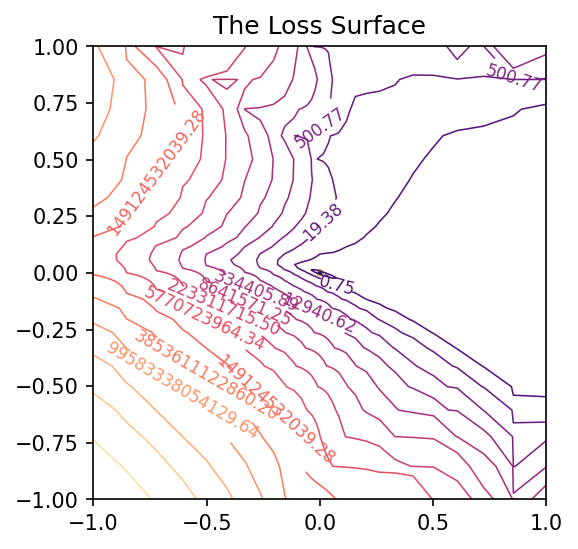

In [53]:
coord = loss_surface_coord(model = model_trained, x = x, y = y, range = 1)

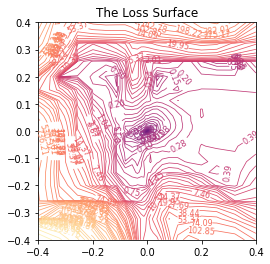

In [54]:
# Create loss surface
coords = RandomCoordinates(model_trained.get_weights())

loss_surface = LossSurface(model_trained , x, y)
loss_surface.compile(points=30, coords=coords, range=0.4)
loss_surface.plot( range=1., points=240, levels=100,)

# **2.3** Модель без начальных весов

Проверим как обучается такая сеть сама

In [20]:
def do_model_without_weights():
  # Create a `Sequential` model and add a Dense layer as the first layer.
  model_without_weights = tf.keras.models.Sequential()
  model_without_weights.add(tf.keras.Input(shape=(1,)))
  model_without_weights.add(tf.keras.layers.Dense(2, use_bias=True ))
  for m in range(mm):
    model_without_weights.add(tf.keras.layers.Dense(5, activation='relu', use_bias=True  ))
    # Now the model will take as input arrays of shape (None, 2)
    # and output arrays of shape (None, 5).
    # Note that after the first layer, you don't need to specify
    # the size of the input anymore:
    model_without_weights.add(tf.keras.layers.Dense(2,  use_bias=True))
  model_without_weights.add(tf.keras.layers.Dense(1,  use_bias=False, kernel_initializer = tf.constant_initializer(np.array([0, 1]))) )
  return model_without_weights


относительная ошибка: 45.49087109375


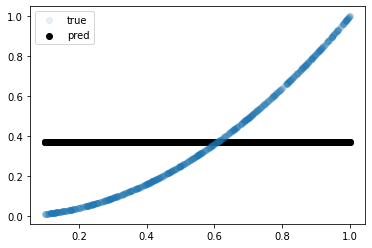

In [21]:
model_without_weights = train(do_model_without_weights())
plot_pred(model_without_weights)

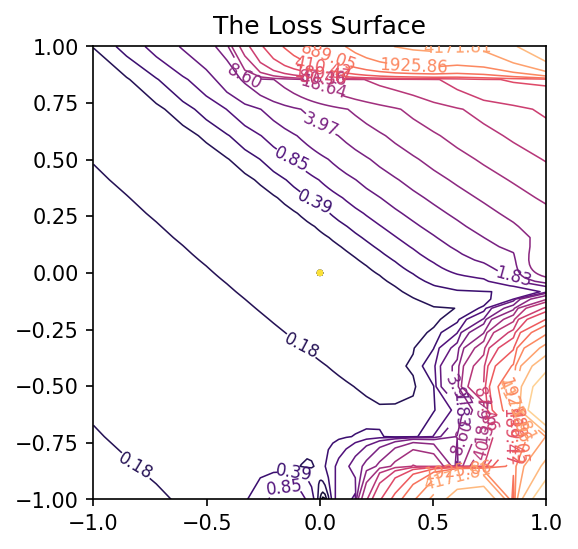

In [57]:
coord = loss_surface_coord(model = model_without_weights, x = x, y = y, range = 1)

# **3 раздел.** Кривизна loss-surface.

Вычислим гессианы модели и сравним их у 3х моделей:

In [22]:
tf.get_logger().setLevel('ERROR')


[Пример вычисления гессина:](https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/guide/advanced_autodiff.ipynb#scrollTo=ELGTaell_j81)


```
x = tf.random.normal([7, 5])
layer1 = tf.keras.layers.Dense(8, activation=tf.nn.relu)
layer2 = tf.keras.layers.Dense(6, activation=tf.nn.relu)

with tf.GradientTape() as t2:
  with tf.GradientTape() as t1:
    x = layer1(x)
    x = layer2(x)
    loss = tf.reduce_mean(x**2)

  g = t1.gradient(loss, layer1.kernel)

h = t2.jacobian(g, layer1.kernel)

```



In [42]:
def mean_hess(model, N = 10, NUM_EXAMPLES = 1000, name_model = 'Great model'):  
  
  mse = tf.keras.losses.MeanSquaredError()
  losses = []
  weights = []
  norms = []
  
  for i in range(N):
      if (name_model != 'Great model'):
      #  if (name_model == 'Without weights'):
      #    model = do_model_without_weights()
      #  if (name_model == 'Init weights'):
      #    model = do_model_trained()
        model = train(model)
      layers = model.layers
      norm1 = []
      x = tf.random.uniform(shape=[NUM_EXAMPLES, 1], minval = 0.1, maxval=1)
      loss = mse(model(x), x**2).numpy()
      losses.append(loss)
      y = x
      for m in range(np.size(layers)):
          weights.append(layers[m].kernel)
          with tf.GradientTape() as t2:
            with tf.GradientTape() as t1:
              for k in range(np.size(layers)):
                  y = layers[k](y)
              loss = tf.reduce_mean(y**2)
            g = t1.gradient(loss, weights[m])
          h = t2.jacobian(g, weights[m]) 
          n_params = tf.reduce_prod(layers[m].kernel.shape)
          g_vec = tf.reshape(g, [n_params, 1])
          h_mat = tf.reshape(h, [n_params, n_params]) # гессиан по одному слою
          #eig = np.linalg.eig(h_mat)
          norm = np.linalg.norm(h_mat, ord = 2) # норма гессиана по одному слою
          norm1.append(norm)  # массив гессианов по всем слоям
      mean_norm = np.mean(norm1) # среднее по всем гессианам модели
      norms.append(mean_norm) 
      #pred = model.predict(x).reshape((1, -1))[0]
      #rse = np.sum(( (pred - y) / y )**2)/NUM_EXAMPLES
      

  plt.scatter(norms, losses, label = str(name_model),  alpha= 0.4)
  plt.xlabel('Hess_norm')
  plt.ylabel('mse')
  plt.legend()
  print('Mean norm :' , np.mean(norms), '+-', np.std(norms))
  print('Mean loss :' , np.mean(losses), '+-', np.std(losses))

  return norms, losses


Without weights:
Mean norm : 0.014313687 +- 0.0006953621
Mean loss : 0.085002534 +- 0.0034313833
Init weights:
Mean norm : 0.21163267 +- 0.01179266
Mean loss : 3.661481e-11 +- 1.6287638e-11
Great model:
Mean norm : 0.21012577 +- 0.013793948
Mean loss : 4.880096e-13 +- 9.286099e-15


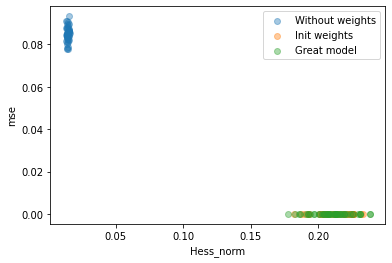

In [48]:

print('Without weights:')
norm_loss2 = mean_hess(model_without_weights, N = 50, name_model='Without weights')
print('Init weights:')
norm_loss3 = mean_hess(model_trained, N = 50, name_model='Init weights')
print('Great model:')
norm_loss1 = mean_hess(model, N = 50, name_model='Great model')

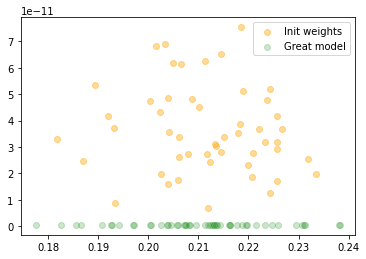

In [52]:
plt.scatter(norm_loss3[0], norm_loss3[1], label = 'Init weights', alpha= 0.4, c = 'orange')
#plt.scatter(norm_loss2[0], norm_loss2[1], label = 'Without weights')
plt.scatter(norm_loss1[0], norm_loss1[1], label = 'Great model', alpha= 0.2, c = 'green')

plt.legend()

Great model:
Mean norm : 0.21385163 +- 0.012738621
Mean loss : 4.8748765e-13 +- 9.764603e-15
Without weights:
Mean norm : 0.6836026 +- 0.027124844
Mean loss : 6.409892e-06 +- 2.4315239e-06
Init weights:
Mean norm : 0.21134333 +- 0.010510008
Mean loss : 3.7726787e-11 +- 2.2181873e-11


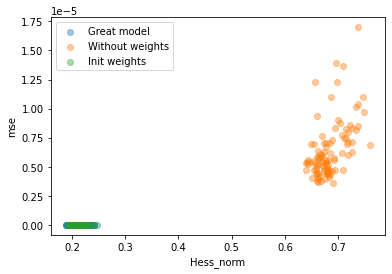

In [62]:
print('Great model:')
norm_loss1 = mean_hess(model, N = 100, name_model='Great model')
print('Without weights:')
norm_loss2 = mean_hess(model_without_weights, N = 100, name_model='Without weights')
print('Init weights:')
norm_loss3 = mean_hess(model_trained, N = 100, name_model='Init weights')

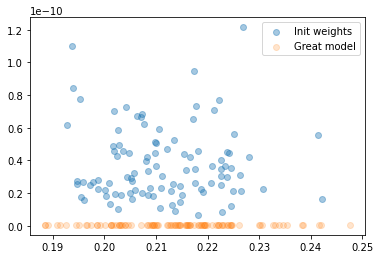

In [68]:
plt.scatter(norm_loss3[0], norm_loss3[1], label = 'Init weights', alpha= 0.4)
#plt.scatter(norm_loss2[0], norm_loss2[1], label = 'Without weights', alpha = 0.6)
plt.scatter(norm_loss1[0], norm_loss1[1], label = 'Great model', alpha= 0.2)

plt.legend()

In [ ]:
#https://stackoverflow.com/questions/11317579/surface-curvature-matlab-equivalent-in-python
def gaussian_curvature(Z):
    Zy, Zx = np.gradient(Z)                                                     
    Zxy, Zxx = np.gradient(Zx)                                                  
    Zyy, _ = np.gradient(Zy)                                                    
    K = (Zxx * Zyy - (Zxy ** 2)) /  (1 + (Zx ** 2) + (Zy **2)) ** 2             
    return K

In [ ]:
#Пример curvature
# https://en.wikipedia.org/wiki/Differential_geometry_of_surfaces
import scipy
def surface_curvature(X,Y,Z):

  (lr,lb)=X.shape

  #print(lr)
	#print("awfshss-------------")
  #print(lb)
#First Derivatives
  Xv,Xu=np.gradient(X)
  Yv,Yu=np.gradient(Y)
  Zv,Zu=np.gradient(Z)
#	print(Xu)

#Second Derivatives
  Xuv,Xuu=np.gradient(Xu)
  Yuv,Yuu=np.gradient(Yu)
  Zuv,Zuu=np.gradient(Zu)   

  Xvv,Xuv=np.gradient(Xv)
  Yvv,Yuv=np.gradient(Yv)
  Zvv,Zuv=np.gradient(Zv) 

#2D to 1D conversion 
#Reshape to 1D vectors
  Xu=np.reshape(Xu,lr*lb)
  Yu=np.reshape(Yu,lr*lb)
  Zu=np.reshape(Zu,lr*lb)
  Xv=np.reshape(Xv,lr*lb)
  Yv=np.reshape(Yv,lr*lb)
  Zv=np.reshape(Zv,lr*lb)
  Xuu=np.reshape(Xuu,lr*lb)
  Yuu=np.reshape(Yuu,lr*lb)
  Zuu=np.reshape(Zuu,lr*lb)
  Xuv=np.reshape(Xuv,lr*lb)
  Yuv=np.reshape(Yuv,lr*lb)
  Zuv=np.reshape(Zuv,lr*lb)
  Xvv=np.reshape(Xvv,lr*lb)
  Yvv=np.reshape(Yvv,lr*lb)
  Zvv=np.reshape(Zvv,lr*lb)

  Xu=np.c_[Xu, Yu, Zu]
  Xv=np.c_[Xv, Yv, Zv]
  Xuu=np.c_[Xuu, Yuu, Zuu]
  Xuv=np.c_[Xuv, Yuv, Zuv]
  Xvv=np.c_[Xvv, Yvv, Zvv]

#% First fundamental Coeffecients of the surface (E,F,G)
	
  E=np.einsum('ij,ij->i', Xu, Xu) 
  F=np.einsum('ij,ij->i', Xu, Xv) 
  G=np.einsum('ij,ij->i', Xv, Xv) 
  
  m=np.cross(Xu,Xv,axisa=1, axisb=1) 
  p=np.sqrt(np.einsum('ij,ij->i', m, m)) 
  n=m/np.c_[p,p,p]
# n is the normal
#% Second fundamental Coeffecients of the surface (L,M,N), (e,f,g)
  L= np.einsum('ij,ij->i', Xuu, n) #e
  M= np.einsum('ij,ij->i', Xuv, n) #f
  N= np.einsum('ij,ij->i', Xvv, n) #g

# Alternative formula for gaussian curvature in wiki 
# K = det(second fundamental) / det(first fundamental)
#% Gaussian Curvature
  K=(L*N-M**2)/(E*G-F**2)
  K=np.reshape(K,lr*lb)
#	print(K.size)
#wiki trace of (second fundamental)(first fundamental inverse)
#% Mean Curvature
  H = ((E*N + G*L - 2*F*M)/((E*G - F**2)))/2
#	print(H.shape)
  H = np.reshape(H,lr*lb)
#	print(H.size)

#% Principle Curvatures
  Pmax = H + np.sqrt(H**2 - K)
  Pmin = H - np.sqrt(H**2 - K)
#[Pmax, Pmin]
  Principle = [Pmax,Pmin]
  PP = np.array(abs(Pmax/Pmin))
  return np.max(PP)


In [ ]:
PrCurv = []
ModelRSE = []

In [ ]:
mm = 9
BATCH_SIZE = 64

for i in range(10):
  # Create a `Sequential` model and add a Dense layer as the first layer.
  model_trained_init_weights = tf.keras.models.Sequential()
  model_trained_init_weights.add(tf.keras.Input(shape=(1,)))
  model_trained_init_weights.add(tf.keras.layers.Dense(2, use_bias=False, kernel_initializer =  tf.constant_initializer(np.array([1., 1.,]).T )))
  for m in range(mm):
    model_trained_init_weights.add(tf.keras.layers.Dense(5, activation='relu', use_bias=True, kernel_initializer = W2, bias_initializer = b2  ))
    # Now the model will take as input arrays of shape (None, 2)
    # and output arrays of shape (None, 5).
    model_trained_init_weights.add(tf.keras.layers.Dense(2,  use_bias=False, kernel_initializer = matr_W1(m+1)))
  model_trained_init_weights.output_shape


  model_trained_init_weights.compile(
    loss='mse',
    optimizer='sgd',
  )
  NUM_EXAMPLES = 200
  x = tf.random.uniform(shape=[NUM_EXAMPLES], minval = 0.1, maxval=1)
  err = tf.random.normal(shape=x.shape, stddev=0.0005)
  y = (x) ** 2  + err
  y = tf.squeeze(y)

  pred = model_trained_init_weights.predict(x)
  rse = np.sum(( (pred.T[1] - y) / y )**2)/NUM_EXAMPLES
  ModelRSE.append(rse)

  ds = (tf.data.Dataset
        .from_tensor_slices((x, y))
        .shuffle(NUM_EXAMPLES)
        .batch(BATCH_SIZE))

  model_trained_init_weights.compile(
    loss='mse',
    optimizer='sgd',
  )
  history = model_trained_init_weights.fit(
    ds,
    epochs=200,
    verbose=0,
  )
  
  x = tf.random.uniform(shape=[NUM_EXAMPLES], minval = 0.1, maxval=1)
  err = tf.random.normal(shape=x.shape, stddev=0.0005)
  y = (x) ** 2  + err
  y = tf.squeeze(y)

  coords = RandomCoordinates(model_trained_init_weights.get_weights())
  loss_surface = LossSurface(model_trained_init_weights , x, y)
  loss_surface.compile(points=30, coords=coords, range=0.1)
  X, Y, Z = loss_surface.z()

  #K = gaussian_curvature(Z)
  #fig = plt.figure(figsize = (12,4))
  #ax = fig.add_subplot(1, 2, 1, projection='3d')
  #ax.plot_surface(X, Y, Z,rstride = 5, cstride = 5, cmap = 'CMRmap', alpha = .9, edgecolor = 'none' )


  [x,y]=scipy.meshgrid(X,Y)
  pr_curv = surface_curvature(x, y, Z)
  #print('Principle curvature ', pr_curv)
  PrCurv.append(pr_curv)

  #loss_surface.plot( range=0.1, points=240, levels=200,)
  #ax = fig.add_subplot(1, 2, 2, projection='3d')
  #ax.plot_surface(X, Y,K,rstride = 5, cstride = 5, cmap = 'CMRmap', alpha = .9, edgecolor = 'none' )



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.meshgrid is deprecated and will be removed in SciPy 2.0.0, use numpy.meshgrid instead


Text(0, 0.5, '$p_\\max/p_\\min$')

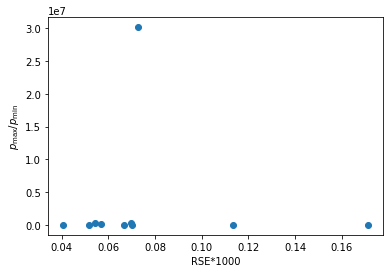

In [ ]:
plt.scatter(np.array(ModelRSE)*1000, PrCurv)
plt.xlabel('RSE*1000')
plt.ylabel('$p_\max/p_\min$')

In [ ]:
#https://stackoverflow.com/questions/11317579/surface-curvature-matlab-equivalent-in-python
def gaussian_curvature(Z):
    Zy, Zx = np.gradient(Z)                                                     
    Zxy, Zxx = np.gradient(Zx)                                                  
    Zyy, _ = np.gradient(Zy)                                                    
    K = (Zxx * Zyy - (Zxy ** 2)) /  (1 + (Zx ** 2) + (Zy **2)) ** 2             
    return K

In [ ]:
loss_surface.compile(points=70, coords=coords, range=0.1)
X, Y, Z = loss_surface.z()
[x,y]=scipy.meshgrid(X,Y)
r = surface_curvature(x, y, Z)
r

70
70


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: scipy.meshgrid is deprecated and will be removed in SciPy 2.0.0, use numpy.meshgrid instead
  This is separate from the ipykernel package so we can avoid doing imports until


array([9.09883955e-04, 6.19318861e-04, 4.81093509e-04, ...,
       1.88147174e-03, 2.89363205e-03, 4.21462756e+01])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: scipy.meshgrid is deprecated and will be removed in SciPy 2.0.0, use numpy.meshgrid instead
  This is separate from the ipykernel package so we can avoid doing imports until


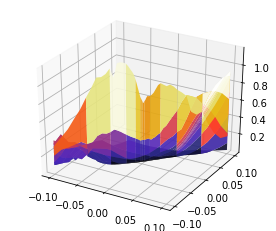

In [ ]:
loss_surface.compile(points=70, coords=coords, range=0.1)
X, Y, Z = loss_surface.z()
[x,y]=scipy.meshgrid(X,Y)

#r = surface_curvature(x, y, Z)
#r = np.array(r).reshape(x.shape)
fig = plt.figure(figsize = (16,4))

ax = fig.add_subplot(1, 3, 1, projection='3d')
ax.plot_surface(X, Y, Z,rstride = 5, cstride = 5, cmap = 'CMRmap', alpha = .9, edgecolor = 'none' )

#ax = fig.add_subplot(1, 3, 2)
#ax.contour(X, Y, r,rstride = 5, cstride = 5, cmap = 'CMRmap', alpha = .9, edgecolor = 'none' )

In [ ]:
Z.shape

(70, 70)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: DeprecationWarning: scipy.meshgrid is deprecated and will be removed in SciPy 2.0.0, use numpy.meshgrid instead


Text(0, 0.5, 'RSE')

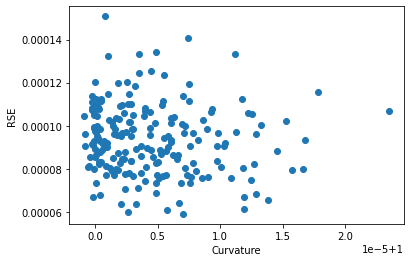

In [ ]:
ModelRSE = []
Curv = []
mm = 9
for k in range(200):
  # Create a `Sequential` model and add a Dense layer as the first layer.
  model_trained_init_weights = tf.keras.models.Sequential()
  model_trained_init_weights.add(tf.keras.Input(shape=(1,)))
  model_trained_init_weights.add(tf.keras.layers.Dense(2, use_bias=False, kernel_initializer =  tf.constant_initializer(np.array([1., 1.,]).T )))
  for m in range(mm):
    model_trained_init_weights.add(tf.keras.layers.Dense(5, activation='relu', use_bias=True , kernel_initializer = W2, bias_initializer = b2  ))
    # Now the model will take as input arrays of shape (None, 2)
    # and output arrays of shape (None, 5).
    model_trained_init_weights.add(tf.keras.layers.Dense(2,  use_bias=False,  kernel_initializer = matr_W1(m+1)))
  model_trained_init_weights.output_shape

  model_trained_init_weights.compile(
    loss='mse',
    optimizer='sgd',
  )

  x = tf.random.uniform(shape=[NUM_EXAMPLES], minval = 0.1, maxval=1)
  err = tf.random.normal(shape=x.shape, stddev=0.0005)
  y = (x) ** 2  + err
  y = tf.squeeze(y)
  pred = model_trained_init_weights.predict(x)
  rse = np.sum(( (pred.T[1] - y) / y )**2)/NUM_EXAMPLES
  ModelRSE.append(rse)
  w1_last = p[-3:][0]
  w2_last = p[-3:][1]
  loss = np.array([np.empty(2), np.empty(2)])
  for i in [ -2, -1]:
    for j in [ -2, -1]:
      model_trained_init_weights.set_weights(coords(p[i][0], p[j][1]))
      loss[i][j] = model_trained_init_weights.test_on_batch( x, y, return_dict=True)["loss"]

  [w1,w2]=scipy.meshgrid(w1_last, w2_last)
  r = surface_curvature(w1, w2, loss)
  Curv.append(r)

plt.scatter(Curv, ModelRSE)
plt.xlabel('Curvature')
plt.ylabel('RSE')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: DeprecationWarning: scipy.meshgrid is deprecated and will be removed in SciPy 2.0.0, use numpy.meshgrid instead


300
300
(90000,)


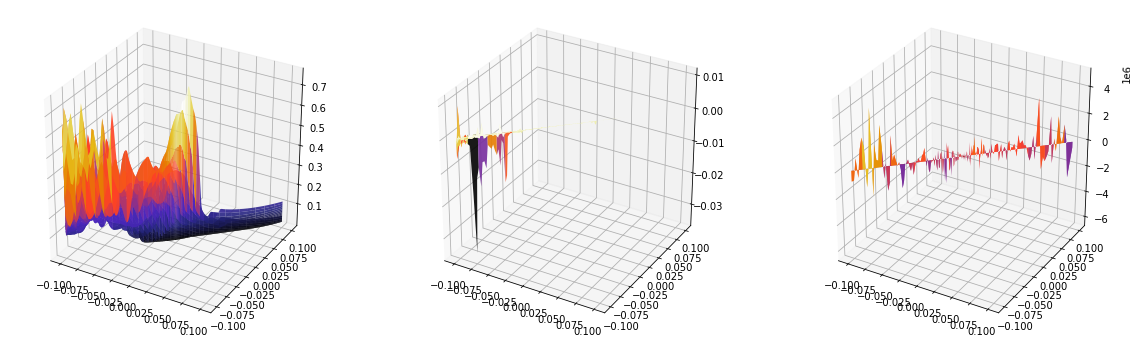

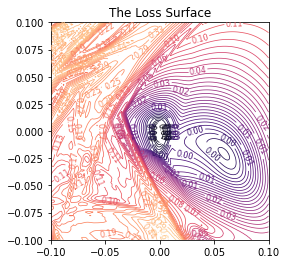

In [ ]:
loss_surface.compile(points=30, coords=coords, range=0.1)
X, Y, Z = loss_surface.z()

K = gaussian_curvature(Z)
fig = plt.figure(figsize = (20,6))
ax = fig.add_subplot(1, 3, 1, projection='3d')
ax.plot_surface(X, Y, Z,rstride = 5, cstride = 5, cmap = 'CMRmap', alpha = .9, edgecolor = 'none' )

ax = fig.add_subplot(1, 3, 2, projection='3d')
ax.plot_surface(X, Y,K,rstride = 5, cstride = 5, cmap = 'CMRmap', alpha = .9, edgecolor = 'none' )

ax = fig.add_subplot(1, 3, 3, projection='3d')
[x,y]=scipy.meshgrid(X,Y)
C = surface_curvature(x,y,Z)
C = np.array(C).reshape(x.shape)
ax.plot_surface(X, Y, C,rstride = 5, cstride = 5, cmap = 'CMRmap', alpha = .9, edgecolor = 'none' )
loss_surface.plot( range=1, points=240, levels=50,)

In [ ]:
x = scipy.linspace(-1,1,200)
y = scipy.linspace(-1,1,200)
[x,y]=scipy.meshgrid(x,y)
print(x.shape)
z = (x**2 - 10 * np.cos(2 * np.pi * x)) + (y**2 - 10 * np.cos(2 * np.pi * y)) + 20
#s = nd.gaussian_filter(z,10)
KH = surface_curvature(x,y,z)

K=np.array(KH[0]).reshape(x.shape)
H=np.array(KH[1]).reshape(x.shape)

In [ ]:
fig = plt.figure(figsize = (17,4))
ax = fig.add_subplot(1, 3, 1, projection='3d')
ax.plot_surface(x,y,z,rstride = 5, cstride = 5, cmap = 'CMRmap', alpha = .9, edgecolor = 'none' )
ax.set_title('$z = x^2 - 10\cos(2 \pi x) + y^2 - 10\cos(2 \pi y) + 20$')
ax = fig.add_subplot(1, 3, 2, projection='3d')
ax.plot_surface(x,y,K,rstride = 5, cstride = 5, cmap = 'CMRmap', alpha = .9, edgecolor = 'none' )
ax.set_title('Gaussian Curvature')
ax = fig.add_subplot(1, 3, 3, projection='3d')
ax.plot_surface(x,y,H,rstride = 5, cstride = 5, cmap = 'CMRmap', alpha = .9, edgecolor = 'none' )
ax.set_title('Mean Curvature')


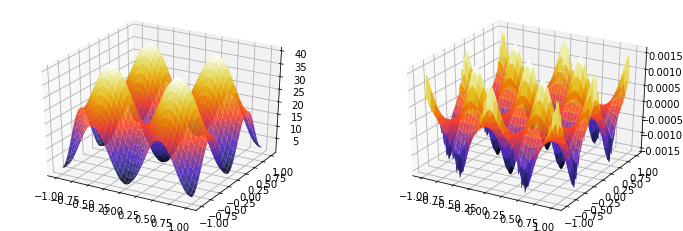

In [ ]:
#https://stackoverflow.com/questions/11317579/surface-curvature-matlab-equivalent-in-python
def gaussian_curvature(Z):
    Zy, Zx = np.gradient(Z)                                                     
    Zxy, Zxx = np.gradient(Zx)                                                  
    Zyy, _ = np.gradient(Zy)                                                    
    K = (Zxx * Zyy - (Zxy ** 2)) /  (1 + (Zx ** 2) + (Zy **2)) ** 2             
    return K
K = gaussian_curvature(z)


fig = plt.figure(figsize = (12,4))
ax = fig.add_subplot(1, 2, 1, projection='3d')
ax.plot_surface(x,y,z,rstride = 5, cstride = 5, cmap = 'CMRmap', alpha = .9, edgecolor = 'none' )

ax = fig.add_subplot(1, 2, 2, projection='3d')
ax.plot_surface(x,y,K,rstride = 5, cstride = 5, cmap = 'CMRmap', alpha = .9, edgecolor = 'none' )